In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

In [2]:
def CARS_simulation_FG(wl1, wl2, floor, nuR1, T21, A1, phi1=0):
    """
    Simulates Coherent Anti-Stokes Raman Scattering (CARS) signal.

    Returns:
    td : Time delay array [fs]
    signal : Simulated CARS signal array [a.u.]
    """
    # ---------------------------------------------------------
    # Constants & Input Parameters
    # ---------------------------------------------------------
    c = 3e10
    tp1,tp2,tp3 = 260,260,200
    tmin, tmax = -3000, 6000
    w1 = 1e7 * 2 * np.pi * c / wl1
    w2 = 1e7 * 2 * np.pi * c / wl2
    wt = w1 - w2
    wR1 = 2 * np.pi * nuR1 * c
    wr1 = (wt - wR1) * 1e-15

    norm = 1e-15  # [fs] to [s] conversion factor

    a12 = -2 * np.log(2) * (1/tp1**2 + 1/tp2**2)

    b21 = -1/T21 - 1j*wr1

    # ---------------------------------------------------------
    # Time grid
    # ---------------------------------------------------------
    step0 = 5
    step1 = 5
    t1 = np.arange(tmin, tmax, step1)
    m1 = len(t1)

    lim = 5 * tp1
    ts = np.arange(-lim, lim, step0)

    Q = np.zeros(m1, dtype=complex)

    # ---------------------------------------------------------
    # Main integration loop
    # ---------------------------------------------------------
    for j1, t in enumerate(t1):

        if t < -lim:
            hs = np.zeros_like(ts)
        elif t > lim:
            hs = np.ones_like(ts)
        else:
            p1 = int(round((t + lim) / step0))
            hs = np.concatenate((np.ones(p1), np.zeros(len(ts) - p1)))
        #hs = np.heaviside(t-ts,1)
        F1 = hs * (
            A1[0] * np.exp(b21[0] * (t - ts) + phi1 * 1j) +
            A1[1] * np.exp(b21[1] * (t - ts))
        ) * np.exp(a12 * ts**2)

        Q[j1] = step0 * np.trapezoid(F1)

    Q11 = (norm * np.abs(Q))**2

    # ---------------------------------------------------------
    # Convolution with probe pulse
    # ---------------------------------------------------------
    a3 = -4 * np.log(2) / tp3**2
    step2 = 5

    td = np.arange(tmin + 5*tp3, tmax - 5*tp3 + step2, step2)
    m2 = len(td)

    signal = np.zeros(m2)

    for j2 in range(m2):
        I3 = np.sqrt(-a3/np.pi) * np.exp(a3 * (t1 - td[j2])**2)
        F2 = Q11 * I3
        signal[j2] = norm * step2 * np.trapezoid(F2) + floor
    return td, signal
    

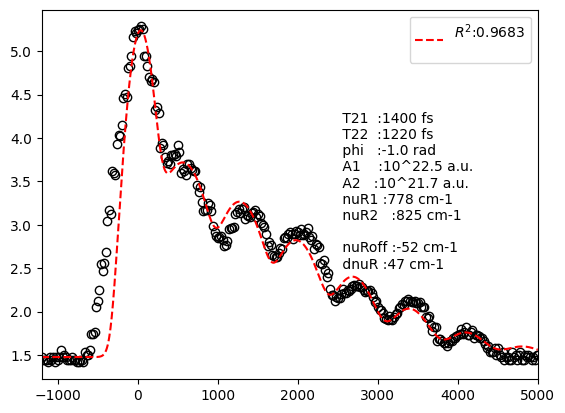

In [ ]:
CARS_file = r"KTP_CARS_3.dat"
data = np.loadtxt(CARS_file, dtype=float, delimiter='\t')
wl1,wl2 = 1013.6, 1109.6
signal_exp_log = np.log10(data[:,1])
td_exp = data[:,0]
x_exp, y_exp = td_exp.copy(), signal_exp_log.copy()
mask = x_exp >= 400
x_exp, y_exp = x_exp[mask], y_exp[mask]
nuR = 1e7*(1/wl1-1/wl2)
floor = 30

#Multi variable fit. ADJUST ONLY TWO PARAMETERS AT A TIME and checking for 10 values each will take ~1min
#TRY CHANGING T21,T22 slightly and look at R-squred value to figureout uncertainity
T21_arr = np.linspace(1400,1450,1)#1400
T22_arr = np.linspace(1220, 1270,1)#1220
dnuR_arr = np.linspace(47,48,1)#47
phi1_arr = np.linspace(-1,0,1)#-1
nuRoff_arr = np.linspace(-52,-52,1)#-52
A1_arr = np.linspace(22.5,22.6,1)#22.5
A2_arr = np.linspace(21.7,21.8,1)#21.7
R2,T21bst,T22bst,dnuRbst,phi1bst,nuRoffbst,A1bst,A2bst = 0,T21_arr[0],T22_arr[0],dnuR_arr[0],phi1_arr[0],nuRoff_arr[0],A1_arr[0],A2_arr[0]

for T21 in T21_arr:
    for T22 in T22_arr:
        for dnuR in dnuR_arr:
            for nuRoff in nuRoff_arr:
                for A1 in A1_arr:
                    for A2 in A2_arr:
                        for phi1 in phi1_arr:
                            nuR1,nuR2 = nuRoff+nuR-dnuR/2, nuRoff+nuR+dnuR/2
                            x_fit, y_fit = CARS_simulation_FG(wl1, wl2, floor, np.array([nuR1,nuR2]), np.array([T21,T22]), np.array([10**A1,10**A2]), phi1)
                            y_fit = np.log10(y_fit)
                            mask = x_fit >= 400
                            x_fit, y_fit = x_fit[mask], y_fit[mask]

                            #calculate R-squared
                            ss_res = np.sum((y_exp - np.interp(x_exp, x_fit, y_fit))**2)
                            ss_tot = np.sum((y_exp - np.mean(y_exp))**2)
                            r_squared = 1 - (ss_res / ss_tot)

                            #store parameters if R-squared is high
                            if r_squared < 1:
                                if r_squared > R2:
                                    R2,T21bst,T22bst,dnuRbst,phi1bst,nuRoffbst,A1bst,A2bst = r_squared,T21,T22,dnuR,phi1,nuRoff,A1,A2

nuR1bst,nuR2bst = nuRoffbst+nuR-dnuRbst/2, nuRoffbst+nuR+dnuRbst/2
x_exp, y_exp = td_exp.copy(), signal_exp_log.copy()
x_fit, y_fit = CARS_simulation_FG(wl1, wl2, floor, np.array([nuR1bst,nuR2bst]), np.array([T21bst,T22bst]), np.array([10**A1bst,10**A2bst]), phi1bst)
x_fit_NR, y_fit_NR = CARS_simulation_FG(wl1, wl2, 1, np.array([nuR1bst,nuR2bst]), np.array([10,10]), np.array([10**22.4,0]), phi1bst)
y_fit = np.log10(y_fit)
plt.plot(x_exp, y_exp, 'ko', mfc = 'none')
plt.plot(x_fit, y_fit + np.log10(y_fit_NR), 'r--', label=r"$R^2$:"+f"{R2:.4f}\n")
plt.text(2500, 2.5, f" T21  :{T21bst:.0f} fs\n T22  :{T22bst:.0f} fs\n phi   :{phi1bst:.1f} rad\n A1    :10^{A1bst:.1f} a.u.\n A2   :10^{A2bst:.1f} a.u.\n nuR1 :{nuR1bst:.0f} cm-1\n nuR2   :{nuR2bst:.0f} cm-1\n\n nuRoff :{nuRoffbst:.0f} cm-1\n dnuR :{dnuRbst:.0f} cm-1")
plt.legend();plt.xlim([-1200, 5000]);plt.show() #0.9683